# Computing features to train a MLP
This notebook will guide you through the use of the `keras` package to train a multilayer perceptron for handwritten digits classification. You are going to computing the histogram of gradients from the images in the `mnist` dataset (LeCun et al. 1998)

## Loading the packages

In [4]:
#%pip install tensorflow --upgrade
#%pip install keras --upgrade

import numpy as np
from matplotlib import pyplot as pl

from skimage.feature import hog
from skimage import data, color, exposure

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

%matplotlib inline

Load the `mnist` dataset and normalize in the range [0, 1]

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, height, width, 1).astype('float32')
X_test = X_test.reshape(n_test, height, width, 1).astype('float32')

X_train /= 255.0
X_test /= 255.0

n_classes = 10

print(n_train, 'train samples')
print(n_test, 'test samples')

# convert class vectors to binary class matrices
Y_train = to_categorical(y_train, n_classes)
Y_test = to_categorical(y_test, n_classes)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
60000 train samples
10000 test samples


### An example of how to compute the histogram of gradients
Let's compute the HOG for one image in the test dataset

In [5]:
n_orientations = 8
pix_p_cell = 4
hog_size = int(height * width * n_orientations / (pix_p_cell * pix_p_cell))

In [6]:
fd, hog_image = hog(X_test[0,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=True)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

Show the image and the corresponding gradients

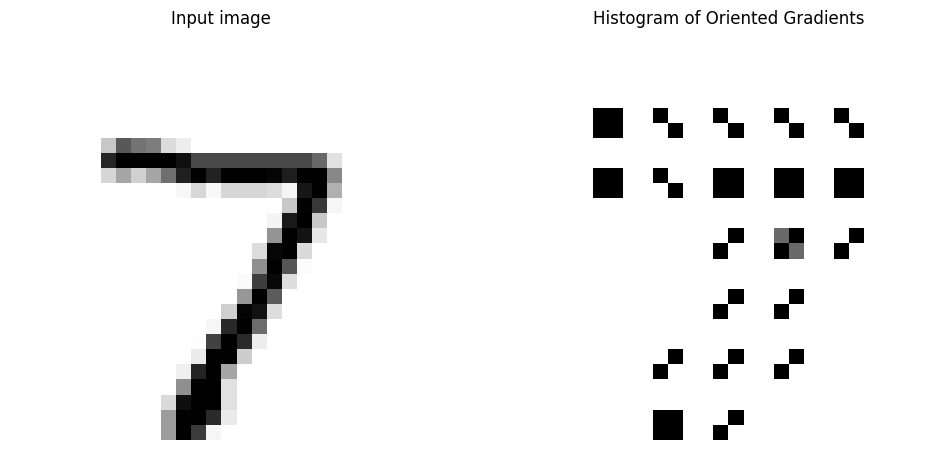

In [7]:
fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(X_test[0,:,:,0], cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax1.set_title('Input image')
ax1.set_adjustable('box')

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box')

Compute the HOGs for the train and test datasets


In [8]:
X_train_hog = np.zeros((X_train.shape[0], hog_size))
X_test_hog = np.zeros((X_test.shape[0], hog_size))

for i in np.arange(X_train_hog.shape[0]):
    X_train_hog[i,:] = hog(X_train[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_train done')

for i in np.arange(X_test_hog.shape[0]):
    X_test_hog[i,:] = hog(X_test[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_test done')

X_train done
X_test done


Create the MLP

In [9]:
model = Sequential()
model.add(Input(shape=(hog_size,)))
model.add(Dense(2, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2)              │           786 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │            30 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 816 (3.19 KB)

 Trainable params: 816 (3.19 KB)

 Non-trainable params: 0 (0.00 B)

Define some constants and train the MLP

In [10]:
batch_size = 128
n_epoch = 50

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

history = model.fit(X_train_hog, Y_train,
                    batch_size=batch_size, epochs=n_epoch,
                    verbose=1, validation_split=0.1)

Epoch 1/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.1847 - loss: 2.0186 - val_accuracy: 0.3922 - val_loss: 1.5300
Epoch 2/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4213 - loss: 1.4848 - val_accuracy: 0.5255 - val_loss: 1.2843
Epoch 3/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5332 - loss: 1.2882 - val_accuracy: 0.5980 - val_loss: 1.1438
Epoch 4/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6036 - loss: 1.1555 - val_accuracy: 0.6583 - val_loss: 1.0460
Epoch 5/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6364 - loss: 1.0693 - val_accuracy: 0.6668 - val_loss: 0.9786
Epoch 6/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6503 - loss: 1.0076 - val_accuracy: 0.6742 - val_loss: 0.9343
Epoch 7/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6654 - loss: 0.9681 - val_accuracy: 0.6908 - val_loss: 0.8993
Epoch 8/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6770 - loss: 0.9320 - val_accuracy: 0.

Show the performance of the model

Test score: 0.6719791293144226
Test accuracy: 0.7886000275611877


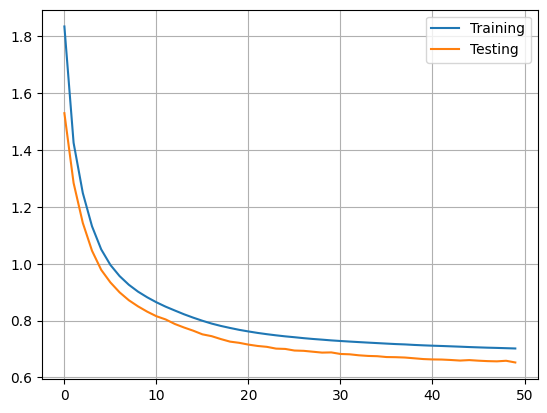

In [11]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

score = model.evaluate(X_test_hog, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Confusion matrix

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
F1 macro Score: 0.7866239795537324
F1 weighted Score: 0.7881170243483568
F1 micro Score: 0.7886


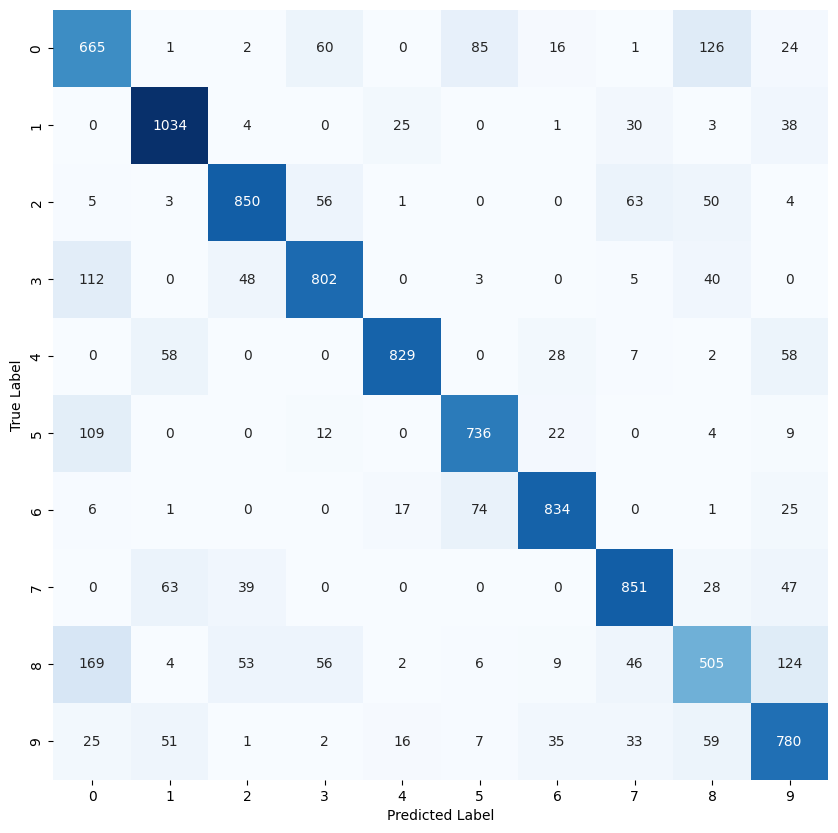

In [12]:
pred = model.predict(X_test_hog)
pred = np.argmax(pred, axis=-1)
confusion_matrix(y_test, pred)

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

f1_score_macro = f1_score(y_test, pred, average='macro')
f1_score_micro = f1_score(y_test, pred, average='micro')
f1_score_weighted = f1_score(y_test, pred, average='weighted')

print(f"F1 macro Score: {f1_score_macro}")
print(f"F1 weighted Score: {f1_score_weighted}")
print(f"F1 micro Score: {f1_score_micro}")